In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# csv = "data.csv"
csv = "pde-miniapp/data.csv"
# csv = "hpc-python/pde-miniapp-py/data.csv"
data = pd.read_csv(csv, sep='\s*,\s*', engine='python')
sns.set_style("ticks")
# data.head()

In [8]:
timeSeq = data[(data['ranks'] == 1) & (data['nx'] == 512)]['time'].mean()
data['speedup'] = timeSeq / data['time']
data['dim'] = ["$%s$" % x for x in data['nx']]
# data['work-per-core'] = np.log(data['nx'] * data['nx'] / data['cores'] / 128 / 128 +1)
data['eff'] = data['speedup'] / data['ranks']
data.head()

ranks   nx   nt    tf  cgIters  newtonIters  cgItersFreq       time  \
0      1  128  100  0.01     7705          869     9436.190   0.816537   
1      1  256  100  0.01    14305          831     2643.970   5.410420   
2      1  512  100  0.01    27428          841      526.127  52.131900   
3      2  128  100  0.01     7715          872    10382.900   0.743048   
4      2  256  100  0.01    14256          823     4408.200   3.233970   

     speedup    dim        eff  
0  63.845117  $128$  63.845117  
1   9.635463  $256$   9.635463  
2   1.000000  $512$   1.000000  
3  70.159532  $128$  35.079766  
4  16.120094  $256$   8.060047

In [9]:
linSU = []
for i in data['ranks'].unique():
    linSU.append([i,i,timeSeq / i])
linSU = pd.DataFrame(linSU, columns=['x', 'speedup', 'time'])
linSU

x  speedup       time
0  1        1  52.131900
1  2        2  26.065950
2  4        4  13.032975
3  6        6   8.688650
4  8        8   6.516488

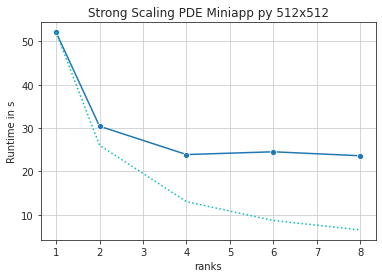

In [10]:
data['nx^2']=data['nx'] * data['nx']
dat=data[data['nx'] == 512]

# Create main plot
ax1 = sns.lineplot(data=dat, x='ranks', y='time', marker='o')

# Add linear speedup line + seq time hline
ax1.plot(linSU['x'], linSU['time'], c='c', ls=':')
# plt.axhline(y=time_serial, color='r', linestyle=':')

# Set plot properties
ax1.set(yscale="linear", ylabel='Runtime in s', title='Strong Scaling PDE Miniapp py 512x512')

plt.grid(True, 'major')
plt.grid(True, 'minor', color='0.85', linestyle='-', linewidth=0.5)
plt.savefig("strong-runtime.pdf", bbox_inches='tight')

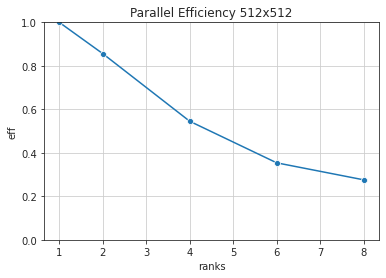

In [11]:
plt.clf()
ax1 = sns.lineplot(data=dat, x='ranks', y='eff',  marker='o')
ax1.set(yscale="linear", title='Parallel Efficiency 512x512')

plt.ylim(0,1)
plt.grid(True, 'major')
plt.grid(True, 'minor', color='0.85', linestyle='-', linewidth=0.5)
plt.savefig("strong-eff.pdf", bbox_inches='tight')

In [12]:
plt.clf()
ax1 = sns.lineplot(data=dat, x='nx', y='newton-iters',  marker='o')
ax1.set(yscale="linear", title='Newton Iterations in relation to the grid size\n for all methods')

plt.grid(True, 'major')
plt.grid(True, 'minor', color='0.85', linestyle='-', linewidth=0.5)
plt.savefig("newton-iters.pdf", bbox_inches='tight')

ValueError: Could not interpret input 'newton-iters'

<Figure size 432x288 with 0 Axes>

# Weak Scaling

In [13]:
# dim=256
# data2=data[data['nx'] == dim]
avgTime = data.groupby(['ranks','nx'], as_index=True)['time'].mean()
print(avgTime)
avgTime = avgTime.to_frame()
avgTime.reset_index(level='ranks', inplace=True)
# avgTime

ranks  nx 
1      128     0.816537
       256     5.410420
       512    52.131900
2      128     0.743048
       256     3.233970
       512    30.446600
4      128     0.963025
       256     2.359010
       512    23.909000
6      128     1.174040
       256     2.367070
       512    24.546500
8      128     1.571750
       256     3.070520
       512    23.627100
Name: time, dtype: float64


In [14]:
linSU = avgTime.query('ranks == 1')
tmp = linSU
for i in np.delete(data['ranks'].unique(),0):
#     print(tmp * [i, 1/i])
#     print(tmp)
    linSU = linSU.append(tmp * [i, 1/i])
linSU.reset_index(inplace=True)
linSU.query('nx == 512')


nx  ranks       time
2   512    1.0  52.131900
5   512    2.0  26.065950
8   512    4.0  13.032975
11  512    6.0   8.688650
14  512    8.0   6.516488

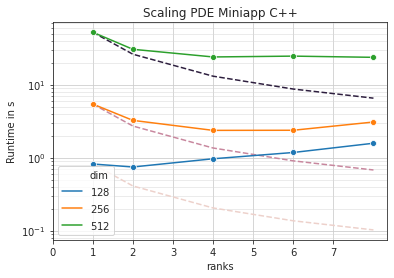

In [16]:
plt.clf()

# Add linear speedup line + seq time hline
ax2 = sns.lineplot(data=linSU, x='ranks', y='time', hue='nx', legend=None)

# Add const work-per-core
# ax3 = sns.lineplot(data=data[data['method'] == 'omp'], x='cores', y='time', hue='work-per-core',
#                    marker='x', color='b', legend=None)

for i in ax2.lines:   #Fix dashes
    i.set_linestyle("--")

# Add main plot (after so it's not dashed)
ax1 = sns.lineplot(data=data, x='ranks', y='time', hue='dim', marker='o', palette='tab10')


# Set plot properties
ax1.set(yscale="log", ylabel='Runtime in s', xlabel='ranks', 
        title='Scaling PDE Miniapp C++')

plt.xticks(np.arange(0, 8, 1))
plt.grid(True, 'major')
plt.grid(True, 'minor', color='0.85', linestyle='-', linewidth=0.5)
plt.savefig("weak-scaling-su.pdf", bbox_inches='tight')